<a href="https://colab.research.google.com/github/roshantac/EVA4-Phase2/blob/master/S7_Variational_AutoEncoders/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Fri Sep 25 04:16:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
!unzip data.zip
!rm -rf data.zip
!mkdir models
!mkdir samples

Archive:  data.zip
   creating: data/
   creating: data/test/
   creating: data/test/data_test/
  inflating: data/test/data_test/desktop.ini  
  inflating: data/test/data_test/img_002.jpg  
  inflating: data/test/data_test/img_005.jpg  
  inflating: data/test/data_test/img_012.jpg  
  inflating: data/test/data_test/img_015.jpg  
  inflating: data/test/data_test/img_022.jpg  
  inflating: data/test/data_test/img_025.jpg  
  inflating: data/test/data_test/img_032.jpg  
  inflating: data/test/data_test/img_035.jpg  
  inflating: data/test/data_test/img_042.jpg  
  inflating: data/test/data_test/img_045.jpg  
  inflating: data/test/data_test/img_052.jpg  
  inflating: data/test/data_test/img_055.jpg  
  inflating: data/test/data_test/img_062.jpg  
  inflating: data/test/data_test/img_065.jpg  
  inflating: data/test/data_test/img_072.jpg  
  inflating: data/test/data_test/img_075.jpg  
  inflating: data/test/data_test/img_082.jpg  
  inflating: data/test/data_test/img_085.jpg  
  inflating

In [3]:
import os
import torch
import time
import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence

In [30]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5)) ])

In [31]:
CUDA = True
SEED = 2
BATCH_SIZE = 32

In [32]:
dataset_test = datasets.ImageFolder('data/test/', transform=transform)
test_loader = DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

dataset_train = datasets.ImageFolder('data/train/', transform=transform)
train_loader = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [33]:

dataiter = iter(train_loader)
# print(dataiter.next())

In [34]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  return np.transpose(img, (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


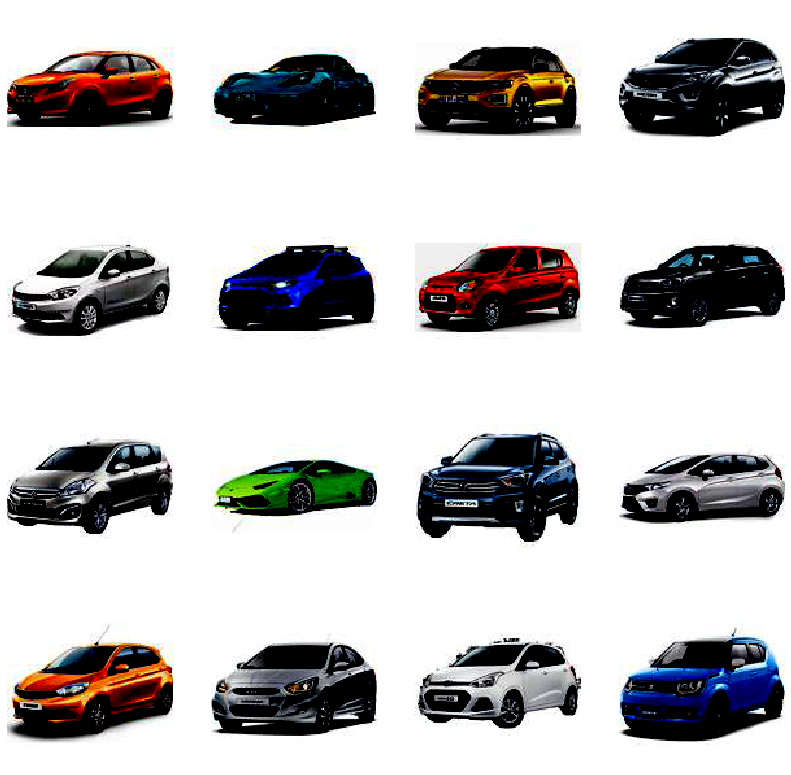

In [35]:
print("Sample Images")
images,labels = dataiter.next()
fig = plt.figure(figsize=(14,14))
for i in range(4):
  for j in range(4):
    idx = i*4 + j
    ax  = plt.subplot(4,4, idx + 1)
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation ='none')
plt.show()

In [36]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)


In [73]:
class VAE(nn.Module):
    def __init__(self, input_dim, dim, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 5, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, z_dim * 2, 3, 1, 0),
            nn.BatchNorm2d(z_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, dim, 3, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 5, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def forward(self, x):
        mu, logvar = self.encoder(x).chunk(2, dim=1)

        q_z_x = Normal(mu, logvar.mul(.5).exp())
        p_z = Normal(torch.zeros_like(mu), torch.ones_like(logvar))
        kl_div = kl_divergence(q_z_x, p_z).sum(1).mean()

        x_tilde = self.decoder(q_z_x.rsample())
        return x_tilde, kl_div


In [74]:
INPUT_DIM = 3
DIM = 4
Z_DIM = 10
model = VAE(INPUT_DIM, DIM, Z_DIM)
if CUDA:
    model.cuda()

In [68]:

!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 64, 64]             196
       BatchNorm2d-2            [-1, 4, 64, 64]               8
              ReLU-3            [-1, 4, 64, 64]               0
            Conv2d-4            [-1, 4, 32, 32]             260
       BatchNorm2d-5            [-1, 4, 32, 32]               8
              ReLU-6            [-1, 4, 32, 32]               0
            Conv2d-7            [-1, 4, 28, 28]             404
       BatchNorm2d-8            [-1, 4, 28, 28]               8
              ReLU-9            [-1, 4, 28, 28]               0
           Conv2d-10           [-1, 20, 26, 26]             740
      BatchNorm2d-11           [-1, 20, 26, 26]              40
  ConvTranspose2d-12            [-1, 4, 28, 28]             364
      BatchNorm2d-13            [-1, 4, 28, 28]               8
             ReLU-14            [-1, 4,

In [75]:
N_EPOCHS = 150
PRINT_INTERVAL = 50
DATASET = 'DATATSET' 
NUM_WORKERS = 4

In [76]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)

In [77]:
def train():
    train_loss = []
    model.train()
    for batch_idx, (x, _) in enumerate(train_loader):
        start_time = time.time()
        x = x.cuda()

        x_tilde, kl_d = model(x)
        loss_recons = F.mse_loss(x_tilde, x, size_average=False) / x.size(0)
        loss = loss_recons + kl_d

        nll = -Normal(x_tilde, torch.ones_like(x_tilde)).log_prob(x)
        log_px = nll.mean().item() - np.log(128) + kl_d.item()
        log_px /= np.log(2)

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss.append([log_px, loss.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), len(train_loader.dataset),
                PRINT_INTERVAL * batch_idx / len(train_loader),
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))


def test():
    start_time = time.time()
    val_loss = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.cuda()
            x_tilde, kl_d = model(x)
            loss_recons = F.mse_loss(x_tilde, x, size_average=False) / x.size(0)
            loss = loss_recons + kl_d
            val_loss.append(loss.item())

    print('\nValidation Completed!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [78]:
def generate_reconstructions():
    model.eval()
    x, _ = test_loader.__iter__().next() 
    x = x[:32].cuda()
    x_tilde, kl_div = model(x)

    x_cat = torch.cat([x, x_tilde], 0)
    images = (x_cat.cpu().data + 1) / 2

    save_image(
        images,
        'samples/vae_reconstructions_{}.png'.format(DATASET),
        nrow=8
    )


def generate_samples():
    model.eval()
    z_e_x = torch.randn(64, Z_DIM, 1, 1).cuda()
    x_tilde = model.decoder(z_e_x)

    images = (x_tilde.cpu().data + 1) / 2

    save_image(
        images,
        'samples/vae_samples_{}.png'.format(DATASET),
        nrow=8
    )


In [ ]:
BEST_LOSS = 99999
LAST_SAVED = -1
for epoch in range(1, N_EPOCHS):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = test()

    if cur_loss <= BEST_LOSS:
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(model.state_dict(), 'models/{}_vae.pt'.format(DATASET))
    else:
        print("Not saving model! Last saved: {}".format(LAST_SAVED))

    generate_reconstructions()
    generate_samples()

Epoch 1:


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Validation Completed!	Loss: 34413.3216 Time: 0.287 s
Saving model!
Epoch 2:

Validation Completed!	Loss: 29346.8600 Time: 0.275 s
Saving model!
Epoch 3:

Validation Completed!	Loss: 21681.6465 Time: 0.273 s
Saving model!
Epoch 4:

Validation Completed!	Loss: 17354.0931 Time: 0.281 s
Saving model!
Epoch 5:

Validation Completed!	Loss: 14544.0286 Time: 0.269 s
Saving model!
Epoch 6:

Validation Completed!	Loss: 12414.7900 Time: 0.287 s
Saving model!
Epoch 7:

Validation Completed!	Loss: 11337.1777 Time: 0.282 s
Saving model!
Epoch 8:

Validation Completed!	Loss: 10474.0046 Time: 0.268 s
Saving model!
Epoch 9:

Validation Completed!	Loss: 10047.6162 Time: 0.289 s
Saving model!
Epoch 10:

Validation Completed!	Loss: 9469.2207 Time: 0.269 s
Saving model!
Epoch 11:

Validation Completed!	Loss: 9129.9753 Time: 0.279 s
Saving model!
Epoch 12:

Validation Completed!	Loss: 8924.8483 Time: 0.268 s
Saving model!
Epoch 13:

Validation Completed!	Loss: 8617.3542 Time: 0.278 s
Saving model!
Epoch 14